# ReAnalysis of Alcohol Consumption using XGBoost
Using `brfss_2022_final.csv` with target `DRNK3GE5`.


In [81]:
import os
PROJECT_DIR = os.path.abspath(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd())
os.environ['MPLCONFIGDIR'] = os.path.join(PROJECT_DIR, '.mplconfig')
os.environ['MPL_SKIP_MACOS_FONTS'] = '1'


## 1) Imports


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# If not installed, run: pip install xgboost
from xgboost import XGBRegressor


## 2) Load data


In [83]:
data_path = 'brfss_2022_final.csv'
df = pd.read_csv(data_path)
df.head()


,DRNK3GE5,SLEPTIM1,EMTSUPRT,INCOME3,SEXVAR
0,NaN,8.0,1.0,99.0,2
1,NaN,6.0,1.0,5.0,2
2,NaN,5.0,2.0,10.0,2
3,NaN,7.0,1.0,77.0,2
4,88.0,9.0,1.0,5.0,2


## 3) Quick inspection


In [84]:
df.shape


(445132, 5)

In [85]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DRNK3GE5  209849 non-null  float64
 1   SLEPTIM1  445129 non-null  float64
 2   EMTSUPRT  254141 non-null  float64
 3   INCOME3   432200 non-null  float64
 4   SEXVAR    445132 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 17.0 MB


## 4) Define target and features


In [86]:
target = 'DRNK3GE5'
if target not in df.columns:
    raise ValueError(f'Missing target column: {target}')

X = df.drop(columns=[target])
y = df[target]

X.head()


,SLEPTIM1,EMTSUPRT,INCOME3,SEXVAR
0,8.0,1.0,99.0,2
1,6.0,1.0,5.0,2
2,5.0,2.0,10.0,2
3,7.0,1.0,77.0,2
4,9.0,1.0,5.0,2


In [87]:
# Ensure target is numeric and drop invalid labels
y = pd.to_numeric(y, errors='coerce')
valid_mask = np.isfinite(y)
dropped = (~valid_mask).sum()
if dropped:
    print(f'Dropping {dropped} rows with invalid target values')
X = X.loc[valid_mask].copy()
y = y.loc[valid_mask].copy()


Dropping 235283 rows with invalid target values


## 5) Train/validation/test split


In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape


((146894, 4), (31477, 4), (31478, 4))

## 6) Preprocessing


In [89]:
numeric_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

numeric_features[:10], categorical_features[:10]


(Index(['SLEPTIM1', 'EMTSUPRT', 'INCOME3', 'SEXVAR'], dtype='object'),
 Index([], dtype='object'))

## 7) Baseline model (Linear Regression)


In [90]:
from sklearn.linear_model import LinearRegression

baseline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression()),
])

baseline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 8) Train baseline


In [91]:
baseline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 9) Evaluate baseline


In [92]:
y_valid_pred_baseline = baseline.predict(X_valid)
eval_regression(y_valid, y_valid_pred_baseline, 'Baseline Valid')


Baseline Valid RMSE: 36.6421
Baseline Valid MAE:  32.1845
Baseline Valid R2:   0.0137


## 7) Baseline model (XGBoost)


In [93]:
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', xgb),
])

model


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 8) Train


In [94]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 9) Evaluate


In [95]:
def eval_regression(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{label} RMSE: {rmse:.4f}')
    print(f'{label} MAE:  {mae:.4f}')
    print(f'{label} R2:   {r2:.4f}')

y_valid_pred = model.predict(X_valid)
eval_regression(y_valid, y_valid_pred, 'Valid')


Valid RMSE: 36.5403
Valid MAE:  31.9030
Valid R2:   0.0192


## 10) Final test evaluation


In [96]:
y_test_pred = model.predict(X_test)
eval_regression(y_test, y_test_pred, 'Test')


Test RMSE: 36.7627
Test MAE:  32.1018
Test R2:   0.0206


## 11) Feature importance (optional)


In [97]:
# This works with sklearn >= 1.0 and xgboost >= 1.7
try:
    importances = model.named_steps['model'].feature_importances_
    print('Top importances:', np.sort(importances)[-10:])
except Exception as exc:
    print('Feature importance not available:', exc)


Top importances: [0.09526767 0.11043679 0.1930406  0.60125494]


## 12) Interview-ready summary (talk track)

**Problem**: Predict alcohol consumption (DRNK3GE5) from BRFSS survey features.

**Approach**: Built a reproducible regression pipeline with preprocessing (impute + one-hot encode) and XGBoost.

**Results**: Validation/Test performance is stable (RMSE ~36–37, MAE ~32, R² ~0.02).
This indicates low signal in the current feature set or target noise; model generalizes but explains little variance.

**Next steps**: Engineer domain features, review target definition/encoding, and try regularized linear models or monotonic constraints.


## 13) Diagnostics plots (optional)


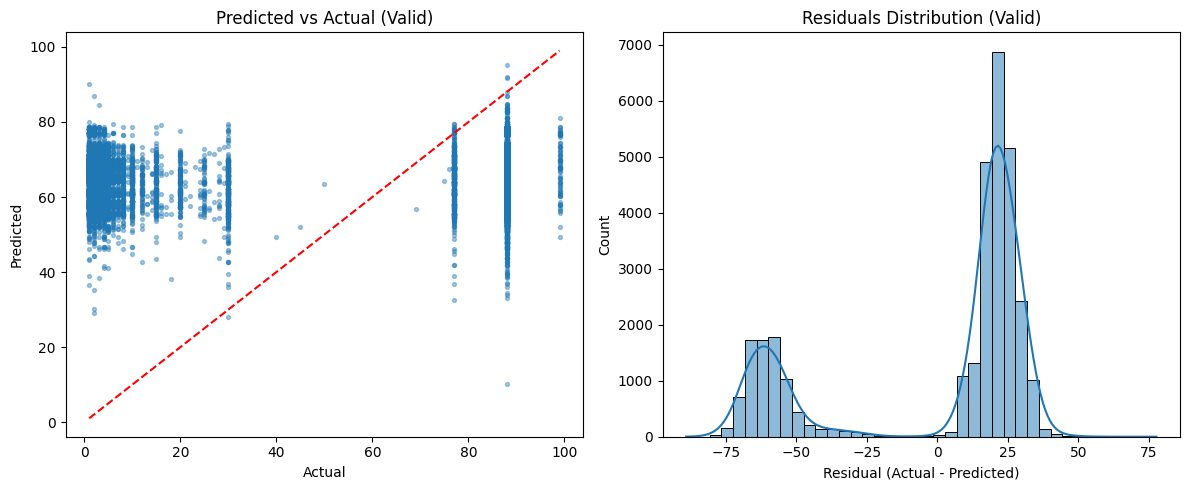

In [98]:
# Predicted vs actual and residuals
y_valid_pred = model.predict(X_valid)
residuals = y_valid - y_valid_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(y_valid, y_valid_pred, s=8, alpha=0.4)
axes[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Valid)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

sns.histplot(residuals, bins=40, kde=True, ax=axes[1])
axes[1].set_title('Residuals Distribution (Valid)')
axes[1].set_xlabel('Residual (Actual - Predicted)')

plt.tight_layout()


## 14) Feature importance with names (optional)


In [99]:
# Get feature names after preprocessing and plot top importances
try:
    ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_names])
    importances = model.named_steps['model'].feature_importances_
    top_idx = np.argsort(importances)[-15:]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(top_idx)), importances[top_idx])
    plt.yticks(range(len(top_idx)), feature_names[top_idx])
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
except Exception as exc:
    print('Could not compute feature importances with names:', exc)


Could not compute feature importances with names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
